
# Loading and normalizing CIFAR10


In [1]:
!pip install albumentations==0.5.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torchvision
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from functools import partial
%matplotlib inline

cv = partial(nn.Conv2d, bias=False)
bn = nn.BatchNorm2d
relu = nn.ReLU

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensor

In [4]:
transform = transforms.Compose([transforms.ToTensor()]) # simple ToTensor for now

train_set = torchvision.datasets.CIFAR10(root='./cifar10', download=True, train=True, transform=transform)


Files already downloaded and verified


In [5]:
train_set.data.shape # train data shape

(50000, 32, 32, 3)

In [6]:
# calculate mean and standard deviation

m = np.mean(train_set.data, axis=(0,1,2))
print(m/255)

s = np.std(train_set.data, axis=(0, 1, 2))
print(s/255)

[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [7]:
mean = m/255
sdev = s/255

In [8]:
SEED = 101
BATCH = 32

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

if cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=BATCH, num_workers=2, pin_memory=True)\
    if cuda else dict(shuffle=True, batch_size=32)


CUDA Available? False


In [9]:
def train_eval_model(model, train_loader, optimizer, device, epochs=1, test=False, test_loader=None, scheduler=None):
          
    model.train() # set the train mode
    
    # iterate over for `epochs` epochs and keep storing valuable info

    for epoch in range(epochs):
      correct = processed = train_loss = 0
    #   if scheduler:
    #     scheduler.step()

      print(f"\n epoch num ================================= {epoch+1}")
      
      pbar = tqdm(train_loader)
      
      for batch_idx, (data, target) in enumerate(pbar):
          data, target = data.to(device), target.to(device) # move data to `device`

          optimizer.zero_grad() # zero out the gradients to avoid accumulating them over loops

          output = model(data) # get the model's predictions

          loss = F.nll_loss(output, target) # calculate Negative Log Likelihood loss using ground truth labels and the model's predictions

          train_loss += loss.item() # add up the train loss

          loss.backward() # The magic function to perform backpropagation and calculate the gradients

          optimizer.step() # take 1 step for the optimizer and update the weights

          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

          correct += pred.eq(target.view_as(pred)).sum().item() #  compare and see how many predictions are coorect and then add up the count

          processed += len(data) # total processed data size

      acc = 100 * correct/processed

      train_losses.append(train_loss)

      train_accuracy.append(acc)

      if scheduler:
        print("\n\n\t\t\tLast LR -->", scheduler.get_last_lr())
        scheduler.step()

      pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
      
      
      train_loss /= len(train_loader.dataset)
      
      print('\n\t\t\tTrain metrics: accuracy: {}/{} ({:.4f}%)'.format(correct,
                                                              len(train_loader.dataset),
                                                              correct * 100 / len(train_loader.dataset)))

      if test: # moving to evaluation
          model.eval() # set the correct mode
          
          correct = test_loss = 0

          with torch.no_grad(): # to disable gradient calculation with no_grad context
              
              for data, target in test_loader:

                  data, target = data.to(device), target.to(device)
                  
                  output = model(data)
                  
                  test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                  
                  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                  
                  correct += pred.eq(target.view_as(pred)).sum().item()

          test_loss /= len(test_loader.dataset)
          test_losses.append(test_loss)
          test_accuracy.append(100. * correct / len(test_loader.dataset))

          print('\n\tTest metrics: average loss: {:.4f}, accuracy: {}/{} ({:.5f}%)\n'.format(
              test_loss, correct, len(test_loader.dataset),
              100. * correct / len(test_loader.dataset)))

In [10]:
def plot_graphs(*, train_losses, train_accuracy, test_losses, test_accuracy):
    fig, axs = plt.subplots(2,2,figsize=(20,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_accuracy)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_accuracy)
    axs[1, 1].set_title("Test Accuracy")

In [11]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="./data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [12]:
# transforms

# here changed CoarseDropout's p to 0.25 from default 0.5
train_transforms = A.Compose([
                                A.HorizontalFlip(p=0.2),
                                A.ShiftScaleRotate(shift_limit=0.1,scale_limit=0.15,rotate_limit=30,p=0.20),
                                A.CoarseDropout(max_holes=1, p=0.15, max_height=16,
                                                max_width=16, min_holes=1, min_height=16,
                                                min_width=16, fill_value=mean),
                                # A.MedianBlur(blur_limit=3, p=0.1),
                                A.HueSaturationValue(p=0.1),
                            #   A.GaussianBlur(blur_limit=3, p=0.12),
                                # A.RandomBrightnessContrast(brightness_limit=0.09,contrast_limit=0.1, p=0.15),   
                                A.Normalize(mean=mean, std=sdev),
                                ToTensor()
                                       ])

test_transforms = A.Compose([
                            A.Normalize(mean=mean, std=sdev),
                            ToTensor()
                                    ])


In [13]:

# data sets with transforms
train_set = Cifar10SearchDataset(train=True, download=True, transform=train_transforms)

test_set = Cifar10SearchDataset(train=False, download=True, transform=test_transforms)


# data loaders on data sets
train_loader = torch.utils.data.DataLoader(dataset=train_set, **dataloader_args)

test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10
Files already downloaded and verified


torch.Size([32, 3, 32, 32])
torch.Size([32])


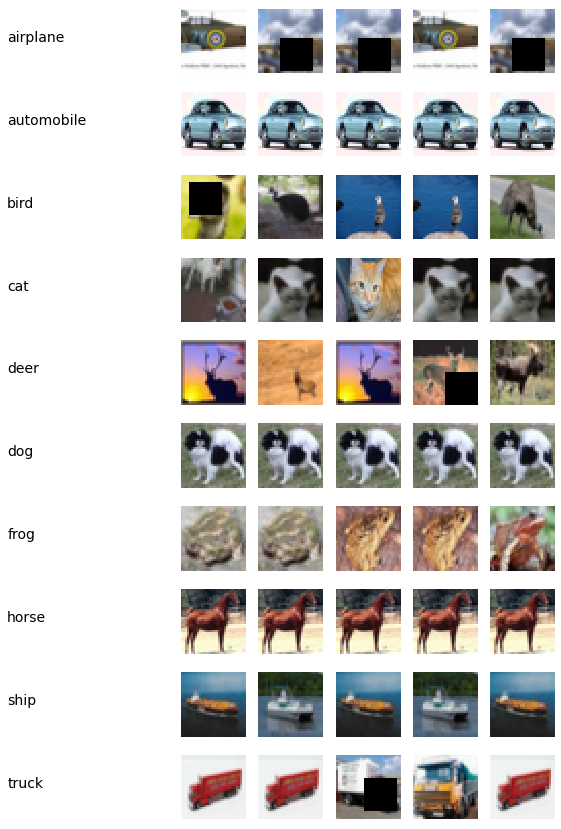

In [14]:
from __future__ import print_function
# channel_means = (0.49196659, 0.48229005, 0.4461573)
# channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*sdev[i])+mean[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

# Code 10

In [ ]:
class Net10(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = nn.Sequential(
            cv(3, 16, 3, padding=1),
            relu(),
            bn(16),
            cv(16, 16, 1),
            relu(),
            bn(16),
            cv(16, 32, 3, dilation=1, groups=1, padding=1),
            relu(),
            bn(32),
            cv(32, 32, 1),
            relu(),
            bn(32),
            nn.Dropout2d(0.05)
        )

        self.block2 = nn.Sequential(
            cv(32, 64, 3, padding=1, dilation=1, groups=32),
            relu(),
            bn(64),
            cv(64, 32, 1),
            relu(),
            bn(32),
            cv(32, 64, 3, dilation=1, padding=1, groups=16),
            relu(),
            bn(64),
            cv(64, 48, 1),
            relu(),
            bn(48),
            cv(48, 64, 3, padding=1, dilation=2, groups=8),
            relu(),
            bn(64),
            cv(64, 32, 1),
            relu(),
            bn(32),
            nn.Dropout2d(0.08)
        )

        self.block3 = nn.Sequential(
            cv(32, 64, 3, dilation=1, padding=1, groups=32, stride=1),
            relu(),
            bn(64),
            cv(64, 128, 3, groups=16, dilation=1, padding=1),
            relu(),
            bn(128),
            cv(128, 64, 1),
            relu(),
            bn(64),
            cv(64, 96, 3, padding=1, groups=32),
            relu(),
            bn(96),
            cv(96, 64, 1),
            relu(),
            bn(64),
            cv(64, 64, 3, padding=2, dilation=2, stride=2),
            relu(),
            bn(64),
            cv(64, 64, 1),
            relu(),
            bn(64),
            nn.Dropout2d(0.09)
            )

        self.block4 = nn.Sequential(
            cv(64, 96, 3, padding=0, groups=32, stride=1, dilation=2),
            bn(96),
            relu(),
            cv(96, 64, 1),
            bn(64),
            relu(),
            nn.Dropout2d(0.05),
            cv(64, 64, 3, groups=64, padding=0, dilation=2), # depthwise (a)
            cv(64, 32, 1), # pointwise for preceding depthwise (b)
            bn(32),
            relu(),
            cv(32, 48, 3, dilation=2, groups=8),
            relu(),
            bn(48),
            cv(48, 10, 1, stride=1),
            relu(),
            bn(10),
            nn.AdaptiveAvgPool2d(1)
            # cv(10, 10, 1)
        )
    
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


model = Net10().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]             256
              ReLU-5           [-1, 16, 32, 32]               0
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 32, 32, 32]           4,608
              ReLU-8           [-1, 32, 32, 32]               0
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           1,024
             ReLU-11           [-1, 32, 32, 32]               0
      BatchNorm2d-12           [-1, 32, 32, 32]              64
        Dropout2d-13           [-1, 32, 32, 32]               0
           Conv2d-14           [-1, 64,

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, nesterov=True)
# step_lr = StepLR(optimizer=optimizer, step_size=1, gamma=0.87)

train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

train_eval_model(model, train_loader, optimizer, device, epochs=50, test=True, test_loader=test_loader,scheduler=None)
torch.save(model, "./eva8_s6_exp_2.pth")


 epoch num ================================= 1


100%|██████████| 1563/1563 [01:05<00:00, 23.73it/s]


			Train metrics: accuracy: 6949/50000 (13.8980%)



	Test metrics: average loss: 2.1395, accuracy: 2017/10000 (20.17000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [01:06<00:00, 23.42it/s]



			Train metrics: accuracy: 12051/50000 (24.1020%)

	Test metrics: average loss: 1.8779, accuracy: 3012/10000 (30.12000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [01:03<00:00, 24.76it/s]


			Train metrics: accuracy: 15877/50000 (31.7540%)



	Test metrics: average loss: 1.6533, accuracy: 3791/10000 (37.91000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [01:02<00:00, 25.02it/s]


			Train metrics: accuracy: 18415/50000 (36.8300%)



	Test metrics: average loss: 1.5874, accuracy: 4169/10000 (41.69000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [01:02<00:00, 25.13it/s]


			Train metrics: accuracy: 19689/50000 (39.3780%)



	Test metrics: average loss: 1.5386, accuracy: 4312/10000 (43.12000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [01:02<00:00, 25.00it/s]


			Train metrics: accuracy: 20783/50000 (41.5660%)



	Test metrics: average loss: 1.4839, accuracy: 4562/10000 (45.62000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [01:02<00:00, 25.10it/s]


			Train metrics: accuracy: 21863/50000 (43.7260%)



	Test metrics: average loss: 1.4351, accuracy: 4658/10000 (46.58000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [01:02<00:00, 24.86it/s]


			Train metrics: accuracy: 22555/50000 (45.1100%)



	Test metrics: average loss: 1.4170, accuracy: 4841/10000 (48.41000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [01:02<00:00, 24.99it/s]


			Train metrics: accuracy: 23149/50000 (46.2980%)



	Test metrics: average loss: 1.3795, accuracy: 4985/10000 (49.85000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [01:02<00:00, 24.98it/s]


			Train metrics: accuracy: 23740/50000 (47.4800%)



	Test metrics: average loss: 1.3433, accuracy: 5137/10000 (51.37000%)


 epoch num ================================= 11


100%|██████████| 1563/1563 [01:02<00:00, 25.01it/s]


			Train metrics: accuracy: 24154/50000 (48.3080%)



	Test metrics: average loss: 1.3150, accuracy: 5200/10000 (52.00000%)


 epoch num ================================= 12


100%|██████████| 1563/1563 [01:02<00:00, 25.02it/s]


			Train metrics: accuracy: 24816/50000 (49.6320%)



	Test metrics: average loss: 1.2852, accuracy: 5324/10000 (53.24000%)


 epoch num ================================= 13


100%|██████████| 1563/1563 [01:03<00:00, 24.69it/s]


			Train metrics: accuracy: 25258/50000 (50.5160%)



	Test metrics: average loss: 1.2851, accuracy: 5389/10000 (53.89000%)


 epoch num ================================= 14


100%|██████████| 1563/1563 [01:02<00:00, 24.88it/s]


			Train metrics: accuracy: 25753/50000 (51.5060%)



	Test metrics: average loss: 1.2580, accuracy: 5443/10000 (54.43000%)


 epoch num ================================= 15


100%|██████████| 1563/1563 [01:02<00:00, 24.89it/s]


			Train metrics: accuracy: 26031/50000 (52.0620%)



	Test metrics: average loss: 1.2386, accuracy: 5531/10000 (55.31000%)


 epoch num ================================= 16


100%|██████████| 1563/1563 [01:02<00:00, 24.88it/s]


			Train metrics: accuracy: 26552/50000 (53.1040%)



	Test metrics: average loss: 1.2105, accuracy: 5590/10000 (55.90000%)


 epoch num ================================= 17


100%|██████████| 1563/1563 [01:03<00:00, 24.75it/s]


			Train metrics: accuracy: 26772/50000 (53.5440%)



	Test metrics: average loss: 1.1743, accuracy: 5758/10000 (57.58000%)


 epoch num ================================= 18


100%|██████████| 1563/1563 [01:02<00:00, 24.93it/s]


			Train metrics: accuracy: 27381/50000 (54.7620%)



	Test metrics: average loss: 1.1658, accuracy: 5757/10000 (57.57000%)


 epoch num ================================= 19


100%|██████████| 1563/1563 [01:02<00:00, 24.84it/s]


			Train metrics: accuracy: 27672/50000 (55.3440%)



	Test metrics: average loss: 1.1497, accuracy: 5913/10000 (59.13000%)


 epoch num ================================= 20


100%|██████████| 1563/1563 [01:03<00:00, 24.80it/s]


			Train metrics: accuracy: 28252/50000 (56.5040%)



	Test metrics: average loss: 1.1220, accuracy: 6023/10000 (60.23000%)


 epoch num ================================= 21


100%|██████████| 1563/1563 [01:02<00:00, 24.93it/s]


			Train metrics: accuracy: 28565/50000 (57.1300%)



	Test metrics: average loss: 1.1074, accuracy: 6027/10000 (60.27000%)


 epoch num ================================= 22


100%|██████████| 1563/1563 [01:02<00:00, 24.85it/s]


			Train metrics: accuracy: 29004/50000 (58.0080%)



	Test metrics: average loss: 1.0979, accuracy: 6050/10000 (60.50000%)


 epoch num ================================= 23


100%|██████████| 1563/1563 [01:03<00:00, 24.71it/s]


			Train metrics: accuracy: 29378/50000 (58.7560%)



	Test metrics: average loss: 1.0582, accuracy: 6230/10000 (62.30000%)


 epoch num ================================= 24


100%|██████████| 1563/1563 [01:02<00:00, 24.95it/s]


			Train metrics: accuracy: 29775/50000 (59.5500%)



	Test metrics: average loss: 1.0701, accuracy: 6190/10000 (61.90000%)


 epoch num ================================= 25


100%|██████████| 1563/1563 [01:02<00:00, 24.88it/s]


			Train metrics: accuracy: 30090/50000 (60.1800%)



	Test metrics: average loss: 1.0458, accuracy: 6276/10000 (62.76000%)


 epoch num ================================= 26


100%|██████████| 1563/1563 [01:03<00:00, 24.59it/s]


			Train metrics: accuracy: 30219/50000 (60.4380%)



	Test metrics: average loss: 1.0488, accuracy: 6313/10000 (63.13000%)


 epoch num ================================= 27


100%|██████████| 1563/1563 [01:03<00:00, 24.71it/s]


			Train metrics: accuracy: 30597/50000 (61.1940%)



	Test metrics: average loss: 1.0118, accuracy: 6375/10000 (63.75000%)


 epoch num ================================= 28


100%|██████████| 1563/1563 [01:02<00:00, 24.87it/s]


			Train metrics: accuracy: 30927/50000 (61.8540%)



	Test metrics: average loss: 0.9949, accuracy: 6435/10000 (64.35000%)


 epoch num ================================= 29


100%|██████████| 1563/1563 [01:02<00:00, 24.94it/s]


			Train metrics: accuracy: 31067/50000 (62.1340%)



	Test metrics: average loss: 0.9859, accuracy: 6485/10000 (64.85000%)


 epoch num ================================= 30


100%|██████████| 1563/1563 [01:02<00:00, 24.87it/s]


			Train metrics: accuracy: 31403/50000 (62.8060%)



	Test metrics: average loss: 0.9590, accuracy: 6591/10000 (65.91000%)


 epoch num ================================= 31


100%|██████████| 1563/1563 [01:03<00:00, 24.79it/s]


			Train metrics: accuracy: 31658/50000 (63.3160%)



	Test metrics: average loss: 0.9477, accuracy: 6635/10000 (66.35000%)


 epoch num ================================= 32


100%|██████████| 1563/1563 [01:02<00:00, 24.89it/s]


			Train metrics: accuracy: 31912/50000 (63.8240%)



	Test metrics: average loss: 0.9480, accuracy: 6600/10000 (66.00000%)


 epoch num ================================= 33


100%|██████████| 1563/1563 [01:02<00:00, 24.95it/s]


			Train metrics: accuracy: 32216/50000 (64.4320%)



	Test metrics: average loss: 0.9363, accuracy: 6633/10000 (66.33000%)


 epoch num ================================= 34


100%|██████████| 1563/1563 [01:02<00:00, 24.90it/s]


			Train metrics: accuracy: 32332/50000 (64.6640%)



	Test metrics: average loss: 0.9212, accuracy: 6723/10000 (67.23000%)


 epoch num ================================= 35


100%|██████████| 1563/1563 [01:02<00:00, 25.02it/s]


			Train metrics: accuracy: 32752/50000 (65.5040%)



	Test metrics: average loss: 0.9338, accuracy: 6717/10000 (67.17000%)


 epoch num ================================= 36


100%|██████████| 1563/1563 [01:02<00:00, 25.02it/s]


			Train metrics: accuracy: 32852/50000 (65.7040%)



	Test metrics: average loss: 0.9013, accuracy: 6844/10000 (68.44000%)


 epoch num ================================= 37


100%|██████████| 1563/1563 [01:02<00:00, 24.90it/s]


			Train metrics: accuracy: 32993/50000 (65.9860%)



	Test metrics: average loss: 0.8840, accuracy: 6903/10000 (69.03000%)


 epoch num ================================= 38


100%|██████████| 1563/1563 [01:02<00:00, 24.87it/s]


			Train metrics: accuracy: 33304/50000 (66.6080%)



	Test metrics: average loss: 0.8791, accuracy: 6880/10000 (68.80000%)


 epoch num ================================= 39


100%|██████████| 1563/1563 [01:02<00:00, 24.82it/s]


			Train metrics: accuracy: 33422/50000 (66.8440%)



	Test metrics: average loss: 0.8705, accuracy: 6897/10000 (68.97000%)


 epoch num ================================= 40


100%|██████████| 1563/1563 [01:02<00:00, 24.90it/s]


			Train metrics: accuracy: 33888/50000 (67.7760%)



	Test metrics: average loss: 0.8575, accuracy: 6958/10000 (69.58000%)


 epoch num ================================= 41


100%|██████████| 1563/1563 [01:03<00:00, 24.74it/s]


			Train metrics: accuracy: 33776/50000 (67.5520%)



	Test metrics: average loss: 0.8519, accuracy: 7043/10000 (70.43000%)


 epoch num ================================= 42


100%|██████████| 1563/1563 [01:04<00:00, 24.11it/s]


			Train metrics: accuracy: 34032/50000 (68.0640%)



	Test metrics: average loss: 0.8541, accuracy: 6968/10000 (69.68000%)


 epoch num ================================= 43


100%|██████████| 1563/1563 [01:02<00:00, 24.88it/s]


			Train metrics: accuracy: 34086/50000 (68.1720%)



	Test metrics: average loss: 0.8403, accuracy: 7034/10000 (70.34000%)


 epoch num ================================= 44


100%|██████████| 1563/1563 [01:02<00:00, 24.92it/s]


			Train metrics: accuracy: 34320/50000 (68.6400%)



	Test metrics: average loss: 0.8278, accuracy: 7102/10000 (71.02000%)


 epoch num ================================= 45


100%|██████████| 1563/1563 [01:02<00:00, 25.10it/s]


			Train metrics: accuracy: 34560/50000 (69.1200%)



	Test metrics: average loss: 0.8315, accuracy: 7092/10000 (70.92000%)


 epoch num ================================= 46


100%|██████████| 1563/1563 [01:02<00:00, 25.05it/s]


			Train metrics: accuracy: 34670/50000 (69.3400%)



	Test metrics: average loss: 0.8254, accuracy: 7108/10000 (71.08000%)


 epoch num ================================= 47


100%|██████████| 1563/1563 [01:02<00:00, 24.99it/s]


			Train metrics: accuracy: 34768/50000 (69.5360%)



	Test metrics: average loss: 0.8096, accuracy: 7145/10000 (71.45000%)


 epoch num ================================= 48


100%|██████████| 1563/1563 [01:02<00:00, 24.88it/s]


			Train metrics: accuracy: 35099/50000 (70.1980%)



	Test metrics: average loss: 0.8484, accuracy: 7095/10000 (70.95000%)


 epoch num ================================= 49


100%|██████████| 1563/1563 [01:02<00:00, 25.08it/s]


			Train metrics: accuracy: 35107/50000 (70.2140%)



	Test metrics: average loss: 0.8014, accuracy: 7209/10000 (72.09000%)


 epoch num ================================= 50


100%|██████████| 1563/1563 [01:03<00:00, 24.57it/s]


			Train metrics: accuracy: 35275/50000 (70.5500%)



	Test metrics: average loss: 0.8059, accuracy: 7192/10000 (71.92000%)



In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

train_eval_model(model, train_loader, optimizer, device, epochs=10, test=True, test_loader=test_loader,scheduler=None)
torch.save(model, "./eva8_s6_exp_2.pth")


 epoch num ================================= 1


100%|██████████| 1563/1563 [01:05<00:00, 24.02it/s]


			Train metrics: accuracy: 20572/50000 (41.1440%)



	Test metrics: average loss: 1.2302, accuracy: 5611/10000 (56.11000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [01:03<00:00, 24.80it/s]


			Train metrics: accuracy: 27153/50000 (54.3060%)



	Test metrics: average loss: 1.1437, accuracy: 6055/10000 (60.55000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [01:02<00:00, 25.05it/s]


			Train metrics: accuracy: 30254/50000 (60.5080%)



	Test metrics: average loss: 0.9730, accuracy: 6599/10000 (65.99000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [01:02<00:00, 25.06it/s]


			Train metrics: accuracy: 31562/50000 (63.1240%)



	Test metrics: average loss: 0.8902, accuracy: 6887/10000 (68.87000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [01:02<00:00, 24.94it/s]


			Train metrics: accuracy: 32651/50000 (65.3020%)



	Test metrics: average loss: 0.8867, accuracy: 6940/10000 (69.40000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [01:02<00:00, 25.05it/s]


			Train metrics: accuracy: 33499/50000 (66.9980%)



	Test metrics: average loss: 0.8353, accuracy: 7077/10000 (70.77000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [01:03<00:00, 24.70it/s]


			Train metrics: accuracy: 34297/50000 (68.5940%)



	Test metrics: average loss: 0.8237, accuracy: 7157/10000 (71.57000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [01:03<00:00, 24.66it/s]


			Train metrics: accuracy: 35036/50000 (70.0720%)



	Test metrics: average loss: 0.7630, accuracy: 7458/10000 (74.58000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [01:02<00:00, 25.07it/s]


			Train metrics: accuracy: 35567/50000 (71.1340%)



	Test metrics: average loss: 0.7374, accuracy: 7469/10000 (74.69000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [01:02<00:00, 24.93it/s]


			Train metrics: accuracy: 36041/50000 (72.0820%)



	Test metrics: average loss: 0.6951, accuracy: 7576/10000 (75.76000%)



In [ ]:
from google.colab import files

files.download( "./eva8_s6_exp_2.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

train_eval_model(model, train_loader, optimizer, device, epochs=20, test=True, test_loader=test_loader,scheduler=None)
torch.save(model, "./eva8_s6_exp_2.pth")


 epoch num ================================= 1


100%|██████████| 1563/1563 [01:08<00:00, 22.91it/s]


			Train metrics: accuracy: 33432/50000 (66.8640%)



	Test metrics: average loss: 0.6537, accuracy: 7787/10000 (77.87000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [01:04<00:00, 24.06it/s]


			Train metrics: accuracy: 37023/50000 (74.0460%)



	Test metrics: average loss: 0.7102, accuracy: 7569/10000 (75.69000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [01:02<00:00, 24.87it/s]


			Train metrics: accuracy: 37307/50000 (74.6140%)



	Test metrics: average loss: 0.6233, accuracy: 7840/10000 (78.40000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [01:03<00:00, 24.51it/s]


			Train metrics: accuracy: 37672/50000 (75.3440%)



	Test metrics: average loss: 0.6472, accuracy: 7750/10000 (77.50000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [01:03<00:00, 24.59it/s]


			Train metrics: accuracy: 37928/50000 (75.8560%)



	Test metrics: average loss: 0.6194, accuracy: 7866/10000 (78.66000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [01:04<00:00, 24.21it/s]


			Train metrics: accuracy: 37993/50000 (75.9860%)



	Test metrics: average loss: 0.6271, accuracy: 7847/10000 (78.47000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [01:03<00:00, 24.73it/s]


			Train metrics: accuracy: 38525/50000 (77.0500%)



	Test metrics: average loss: 0.6146, accuracy: 7885/10000 (78.85000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [01:03<00:00, 24.74it/s]


			Train metrics: accuracy: 38369/50000 (76.7380%)



	Test metrics: average loss: 0.5968, accuracy: 7934/10000 (79.34000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [01:03<00:00, 24.79it/s]


			Train metrics: accuracy: 38587/50000 (77.1740%)



	Test metrics: average loss: 0.6056, accuracy: 7895/10000 (78.95000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [01:02<00:00, 24.88it/s]


			Train metrics: accuracy: 38754/50000 (77.5080%)



	Test metrics: average loss: 0.6035, accuracy: 7951/10000 (79.51000%)


 epoch num ================================= 11


100%|██████████| 1563/1563 [01:03<00:00, 24.75it/s]


			Train metrics: accuracy: 39011/50000 (78.0220%)



	Test metrics: average loss: 0.5900, accuracy: 7967/10000 (79.67000%)


 epoch num ================================= 12


100%|██████████| 1563/1563 [01:02<00:00, 24.94it/s]


			Train metrics: accuracy: 39098/50000 (78.1960%)



	Test metrics: average loss: 0.5724, accuracy: 8049/10000 (80.49000%)


 epoch num ================================= 13


100%|██████████| 1563/1563 [01:02<00:00, 25.07it/s]


			Train metrics: accuracy: 39224/50000 (78.4480%)



	Test metrics: average loss: 0.6244, accuracy: 7904/10000 (79.04000%)


 epoch num ================================= 14


100%|██████████| 1563/1563 [01:02<00:00, 25.08it/s]


			Train metrics: accuracy: 39417/50000 (78.8340%)



	Test metrics: average loss: 0.5883, accuracy: 8027/10000 (80.27000%)


 epoch num ================================= 15


100%|██████████| 1563/1563 [01:03<00:00, 24.71it/s]


			Train metrics: accuracy: 39502/50000 (79.0040%)



	Test metrics: average loss: 0.5627, accuracy: 8087/10000 (80.87000%)


 epoch num ================================= 16


100%|██████████| 1563/1563 [01:03<00:00, 24.65it/s]


			Train metrics: accuracy: 39650/50000 (79.3000%)



	Test metrics: average loss: 0.5792, accuracy: 8012/10000 (80.12000%)


 epoch num ================================= 17


100%|██████████| 1563/1563 [01:05<00:00, 23.71it/s]


			Train metrics: accuracy: 39781/50000 (79.5620%)



	Test metrics: average loss: 0.5864, accuracy: 8017/10000 (80.17000%)


 epoch num ================================= 18


100%|██████████| 1563/1563 [01:02<00:00, 25.08it/s]


			Train metrics: accuracy: 39790/50000 (79.5800%)



	Test metrics: average loss: 0.5839, accuracy: 8012/10000 (80.12000%)


 epoch num ================================= 19


100%|██████████| 1563/1563 [01:03<00:00, 24.56it/s]


			Train metrics: accuracy: 39867/50000 (79.7340%)



	Test metrics: average loss: 0.5872, accuracy: 8043/10000 (80.43000%)


 epoch num ================================= 20


100%|██████████| 1563/1563 [01:02<00:00, 24.90it/s]


			Train metrics: accuracy: 39820/50000 (79.6400%)



	Test metrics: average loss: 0.5456, accuracy: 8125/10000 (81.25000%)



In [ ]:
files.download( "./eva8_s6_exp_2.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.0003, momentum=0.9, nesterov=True)

train_eval_model(model, train_loader, optimizer, device, epochs=50, test=True, test_loader=test_loader,scheduler=None)

torch.save(model, "./eva8_s6_exp_2_lr0003_epochs40.pth")
files.download("./eva8_s6_exp_2_lr0003_epochs40.pth")


 epoch num ================================= 1


100%|██████████| 1563/1563 [01:04<00:00, 24.13it/s]


			Train metrics: accuracy: 33009/50000 (66.0180%)



	Test metrics: average loss: 0.6735, accuracy: 7995/10000 (79.95000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [01:02<00:00, 24.86it/s]


			Train metrics: accuracy: 39763/50000 (79.5260%)



	Test metrics: average loss: 0.5286, accuracy: 8153/10000 (81.53000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [01:02<00:00, 24.94it/s]


			Train metrics: accuracy: 40786/50000 (81.5720%)



	Test metrics: average loss: 0.5060, accuracy: 8251/10000 (82.51000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [01:02<00:00, 25.03it/s]


			Train metrics: accuracy: 41146/50000 (82.2920%)



	Test metrics: average loss: 0.4955, accuracy: 8291/10000 (82.91000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [01:02<00:00, 25.08it/s]


			Train metrics: accuracy: 41442/50000 (82.8840%)



	Test metrics: average loss: 0.4895, accuracy: 8305/10000 (83.05000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [01:02<00:00, 24.93it/s]


			Train metrics: accuracy: 41540/50000 (83.0800%)



	Test metrics: average loss: 0.4855, accuracy: 8342/10000 (83.42000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [01:02<00:00, 24.97it/s]


			Train metrics: accuracy: 41838/50000 (83.6760%)



	Test metrics: average loss: 0.4828, accuracy: 8340/10000 (83.40000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [01:02<00:00, 25.07it/s]


			Train metrics: accuracy: 41919/50000 (83.8380%)



	Test metrics: average loss: 0.4791, accuracy: 8361/10000 (83.61000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [01:02<00:00, 25.05it/s]


			Train metrics: accuracy: 41988/50000 (83.9760%)



	Test metrics: average loss: 0.4747, accuracy: 8361/10000 (83.61000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [01:02<00:00, 24.93it/s]


			Train metrics: accuracy: 42102/50000 (84.2040%)



	Test metrics: average loss: 0.4742, accuracy: 8379/10000 (83.79000%)


 epoch num ================================= 11


100%|██████████| 1563/1563 [01:02<00:00, 25.04it/s]


			Train metrics: accuracy: 42229/50000 (84.4580%)



	Test metrics: average loss: 0.4728, accuracy: 8373/10000 (83.73000%)


 epoch num ================================= 12


100%|██████████| 1563/1563 [01:02<00:00, 25.10it/s]


			Train metrics: accuracy: 42271/50000 (84.5420%)



	Test metrics: average loss: 0.4726, accuracy: 8396/10000 (83.96000%)


 epoch num ================================= 13


100%|██████████| 1563/1563 [01:02<00:00, 25.10it/s]


			Train metrics: accuracy: 42404/50000 (84.8080%)



	Test metrics: average loss: 0.4681, accuracy: 8406/10000 (84.06000%)


 epoch num ================================= 14


100%|██████████| 1563/1563 [01:02<00:00, 24.89it/s]


			Train metrics: accuracy: 42427/50000 (84.8540%)



	Test metrics: average loss: 0.4726, accuracy: 8392/10000 (83.92000%)


 epoch num ================================= 15


100%|██████████| 1563/1563 [01:02<00:00, 25.03it/s]


			Train metrics: accuracy: 42490/50000 (84.9800%)



	Test metrics: average loss: 0.4686, accuracy: 8388/10000 (83.88000%)


 epoch num ================================= 16


100%|██████████| 1563/1563 [01:02<00:00, 24.83it/s]


			Train metrics: accuracy: 42652/50000 (85.3040%)



	Test metrics: average loss: 0.4668, accuracy: 8413/10000 (84.13000%)


 epoch num ================================= 17


100%|██████████| 1563/1563 [01:02<00:00, 24.82it/s]


			Train metrics: accuracy: 42566/50000 (85.1320%)



	Test metrics: average loss: 0.4625, accuracy: 8423/10000 (84.23000%)


 epoch num ================================= 18


100%|██████████| 1563/1563 [01:02<00:00, 24.88it/s]


			Train metrics: accuracy: 42643/50000 (85.2860%)



	Test metrics: average loss: 0.4647, accuracy: 8420/10000 (84.20000%)


 epoch num ================================= 19


100%|██████████| 1563/1563 [01:02<00:00, 25.03it/s]


			Train metrics: accuracy: 42663/50000 (85.3260%)



	Test metrics: average loss: 0.4628, accuracy: 8438/10000 (84.38000%)


 epoch num ================================= 20


100%|██████████| 1563/1563 [01:02<00:00, 25.00it/s]


			Train metrics: accuracy: 42765/50000 (85.5300%)



	Test metrics: average loss: 0.4633, accuracy: 8433/10000 (84.33000%)


 epoch num ================================= 21


100%|██████████| 1563/1563 [01:02<00:00, 25.03it/s]


			Train metrics: accuracy: 42740/50000 (85.4800%)



	Test metrics: average loss: 0.4617, accuracy: 8438/10000 (84.38000%)


 epoch num ================================= 22


100%|██████████| 1563/1563 [01:02<00:00, 24.92it/s]


			Train metrics: accuracy: 42741/50000 (85.4820%)



	Test metrics: average loss: 0.4628, accuracy: 8445/10000 (84.45000%)


 epoch num ================================= 23


100%|██████████| 1563/1563 [01:02<00:00, 25.05it/s]


			Train metrics: accuracy: 42846/50000 (85.6920%)



	Test metrics: average loss: 0.4626, accuracy: 8421/10000 (84.21000%)


 epoch num ================================= 24


100%|██████████| 1563/1563 [01:02<00:00, 25.03it/s]


			Train metrics: accuracy: 42790/50000 (85.5800%)



	Test metrics: average loss: 0.4639, accuracy: 8433/10000 (84.33000%)


 epoch num ================================= 25


100%|██████████| 1563/1563 [01:02<00:00, 25.06it/s]


			Train metrics: accuracy: 42866/50000 (85.7320%)



	Test metrics: average loss: 0.4598, accuracy: 8438/10000 (84.38000%)


 epoch num ================================= 26


100%|██████████| 1563/1563 [01:02<00:00, 24.90it/s]


			Train metrics: accuracy: 42954/50000 (85.9080%)



	Test metrics: average loss: 0.4664, accuracy: 8438/10000 (84.38000%)


 epoch num ================================= 27


100%|██████████| 1563/1563 [01:03<00:00, 24.76it/s]


			Train metrics: accuracy: 42931/50000 (85.8620%)



	Test metrics: average loss: 0.4584, accuracy: 8451/10000 (84.51000%)


 epoch num ================================= 28


100%|██████████| 1563/1563 [01:02<00:00, 25.00it/s]


			Train metrics: accuracy: 43010/50000 (86.0200%)



	Test metrics: average loss: 0.4603, accuracy: 8452/10000 (84.52000%)


 epoch num ================================= 29


100%|██████████| 1563/1563 [01:02<00:00, 24.93it/s]


			Train metrics: accuracy: 42980/50000 (85.9600%)



	Test metrics: average loss: 0.4611, accuracy: 8445/10000 (84.45000%)


 epoch num ================================= 30


100%|██████████| 1563/1563 [01:06<00:00, 23.58it/s]


			Train metrics: accuracy: 43026/50000 (86.0520%)



	Test metrics: average loss: 0.4563, accuracy: 8465/10000 (84.65000%)


 epoch num ================================= 31


100%|██████████| 1563/1563 [01:02<00:00, 24.92it/s]


			Train metrics: accuracy: 43128/50000 (86.2560%)



	Test metrics: average loss: 0.4609, accuracy: 8447/10000 (84.47000%)


 epoch num ================================= 32


100%|██████████| 1563/1563 [01:02<00:00, 24.98it/s]


			Train metrics: accuracy: 43107/50000 (86.2140%)



	Test metrics: average loss: 0.4587, accuracy: 8457/10000 (84.57000%)


 epoch num ================================= 33


100%|██████████| 1563/1563 [01:02<00:00, 25.02it/s]


			Train metrics: accuracy: 43041/50000 (86.0820%)



	Test metrics: average loss: 0.4607, accuracy: 8464/10000 (84.64000%)


 epoch num ================================= 34


100%|██████████| 1563/1563 [01:04<00:00, 24.35it/s]


			Train metrics: accuracy: 43144/50000 (86.2880%)



	Test metrics: average loss: 0.4584, accuracy: 8467/10000 (84.67000%)


 epoch num ================================= 35


100%|██████████| 1563/1563 [01:03<00:00, 24.73it/s]


			Train metrics: accuracy: 43135/50000 (86.2700%)



	Test metrics: average loss: 0.4586, accuracy: 8484/10000 (84.84000%)


 epoch num ================================= 36


100%|██████████| 1563/1563 [01:02<00:00, 24.98it/s]


			Train metrics: accuracy: 43230/50000 (86.4600%)



	Test metrics: average loss: 0.4571, accuracy: 8485/10000 (84.85000%)


 epoch num ================================= 37


100%|██████████| 1563/1563 [01:02<00:00, 24.92it/s]


			Train metrics: accuracy: 43227/50000 (86.4540%)



	Test metrics: average loss: 0.4605, accuracy: 8455/10000 (84.55000%)


 epoch num ================================= 38


100%|██████████| 1563/1563 [01:03<00:00, 24.74it/s]


			Train metrics: accuracy: 43232/50000 (86.4640%)



	Test metrics: average loss: 0.4621, accuracy: 8448/10000 (84.48000%)


 epoch num ================================= 39


100%|██████████| 1563/1563 [01:02<00:00, 25.04it/s]


			Train metrics: accuracy: 43225/50000 (86.4500%)



	Test metrics: average loss: 0.4568, accuracy: 8467/10000 (84.67000%)


 epoch num ================================= 40


100%|██████████| 1563/1563 [01:02<00:00, 25.01it/s]


			Train metrics: accuracy: 43335/50000 (86.6700%)



	Test metrics: average loss: 0.4609, accuracy: 8460/10000 (84.60000%)


 epoch num ================================= 41


100%|██████████| 1563/1563 [01:02<00:00, 25.02it/s]


			Train metrics: accuracy: 43225/50000 (86.4500%)



	Test metrics: average loss: 0.4612, accuracy: 8463/10000 (84.63000%)


 epoch num ================================= 42


100%|██████████| 1563/1563 [01:02<00:00, 24.86it/s]


			Train metrics: accuracy: 43261/50000 (86.5220%)



	Test metrics: average loss: 0.4576, accuracy: 8474/10000 (84.74000%)


 epoch num ================================= 43


100%|██████████| 1563/1563 [01:02<00:00, 25.05it/s]


			Train metrics: accuracy: 43328/50000 (86.6560%)



	Test metrics: average loss: 0.4604, accuracy: 8473/10000 (84.73000%)


 epoch num ================================= 44


100%|██████████| 1563/1563 [01:04<00:00, 24.05it/s]


			Train metrics: accuracy: 43383/50000 (86.7660%)



	Test metrics: average loss: 0.4585, accuracy: 8490/10000 (84.90000%)


 epoch num ================================= 45


100%|██████████| 1563/1563 [01:04<00:00, 24.14it/s]


			Train metrics: accuracy: 43430/50000 (86.8600%)



	Test metrics: average loss: 0.4574, accuracy: 8461/10000 (84.61000%)


 epoch num ================================= 46


100%|██████████| 1563/1563 [01:03<00:00, 24.71it/s]


			Train metrics: accuracy: 43398/50000 (86.7960%)



	Test metrics: average loss: 0.4605, accuracy: 8469/10000 (84.69000%)


 epoch num ================================= 47


100%|██████████| 1563/1563 [01:02<00:00, 24.92it/s]


			Train metrics: accuracy: 43350/50000 (86.7000%)



	Test metrics: average loss: 0.4592, accuracy: 8471/10000 (84.71000%)


 epoch num ================================= 48


100%|██████████| 1563/1563 [01:05<00:00, 24.00it/s]


			Train metrics: accuracy: 43496/50000 (86.9920%)



	Test metrics: average loss: 0.4607, accuracy: 8471/10000 (84.71000%)


 epoch num ================================= 49


100%|██████████| 1563/1563 [01:02<00:00, 24.83it/s]


			Train metrics: accuracy: 43351/50000 (86.7020%)



	Test metrics: average loss: 0.4583, accuracy: 8481/10000 (84.81000%)


 epoch num ================================= 50


100%|██████████| 1563/1563 [01:02<00:00, 24.90it/s]


			Train metrics: accuracy: 43505/50000 (87.0100%)



	Test metrics: average loss: 0.4630, accuracy: 8457/10000 (84.57000%)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)

step_lr = StepLR(optimizer=optimizer, step_size=2, gamma=0.81, verbose=True)

train_eval_model(model, train_loader, optimizer, device, epochs=50, test=True,
                 test_loader=test_loader,
                 scheduler=step_lr)

torch.save(model, "./eva8_s6_steplr1_epochs50.pth")
files.download("./eva8_s6_steplr1_epochs50.pth")

Adjusting learning rate of group 0 to 1.0000e-03.

 epoch num ================================= 1


100%|██████████| 1563/1563 [01:04<00:00, 24.18it/s]



			Last LR --> [0.001]
Adjusting learning rate of group 0 to 1.0000e-03.

			Train metrics: accuracy: 35712/50000 (71.4240%)



	Test metrics: average loss: 0.5265, accuracy: 8308/10000 (83.08000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [01:02<00:00, 25.11it/s]



			Last LR --> [0.001]
Adjusting learning rate of group 0 to 8.1000e-04.

			Train metrics: accuracy: 42312/50000 (84.6240%)



	Test metrics: average loss: 0.4575, accuracy: 8436/10000 (84.36000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [01:02<00:00, 25.07it/s]



			Last LR --> [0.0008100000000000001]
Adjusting learning rate of group 0 to 8.1000e-04.

			Train metrics: accuracy: 42852/50000 (85.7040%)



	Test metrics: average loss: 0.4555, accuracy: 8419/10000 (84.19000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [01:02<00:00, 24.95it/s]



			Last LR --> [0.0008100000000000001]
Adjusting learning rate of group 0 to 6.5610e-04.

			Train metrics: accuracy: 43020/50000 (86.0400%)



	Test metrics: average loss: 0.4528, accuracy: 8453/10000 (84.53000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [01:02<00:00, 25.13it/s]



			Last LR --> [0.0006561000000000001]
Adjusting learning rate of group 0 to 6.5610e-04.

			Train metrics: accuracy: 43192/50000 (86.3840%)



	Test metrics: average loss: 0.4519, accuracy: 8499/10000 (84.99000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [01:02<00:00, 25.06it/s]



			Last LR --> [0.0006561000000000001]
Adjusting learning rate of group 0 to 5.3144e-04.

			Train metrics: accuracy: 43363/50000 (86.7260%)



	Test metrics: average loss: 0.4552, accuracy: 8482/10000 (84.82000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [01:02<00:00, 25.00it/s]



			Last LR --> [0.0005314410000000001]
Adjusting learning rate of group 0 to 5.3144e-04.

			Train metrics: accuracy: 43420/50000 (86.8400%)



	Test metrics: average loss: 0.4581, accuracy: 8452/10000 (84.52000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [01:02<00:00, 24.90it/s]



			Last LR --> [0.0005314410000000001]
Adjusting learning rate of group 0 to 4.3047e-04.

			Train metrics: accuracy: 43395/50000 (86.7900%)



	Test metrics: average loss: 0.4614, accuracy: 8451/10000 (84.51000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [01:02<00:00, 25.07it/s]



			Last LR --> [0.0004304672100000001]
Adjusting learning rate of group 0 to 4.3047e-04.

			Train metrics: accuracy: 43444/50000 (86.8880%)



	Test metrics: average loss: 0.4584, accuracy: 8481/10000 (84.81000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [01:02<00:00, 24.89it/s]



			Last LR --> [0.0004304672100000001]
Adjusting learning rate of group 0 to 3.4868e-04.

			Train metrics: accuracy: 43516/50000 (87.0320%)



	Test metrics: average loss: 0.4570, accuracy: 8479/10000 (84.79000%)


 epoch num ================================= 11


100%|██████████| 1563/1563 [01:03<00:00, 24.74it/s]



			Last LR --> [0.0003486784401000001]
Adjusting learning rate of group 0 to 3.4868e-04.

			Train metrics: accuracy: 43582/50000 (87.1640%)



	Test metrics: average loss: 0.4560, accuracy: 8507/10000 (85.07000%)


 epoch num ================================= 12


100%|██████████| 1563/1563 [01:02<00:00, 24.90it/s]



			Last LR --> [0.0003486784401000001]
Adjusting learning rate of group 0 to 2.8243e-04.

			Train metrics: accuracy: 43546/50000 (87.0920%)



	Test metrics: average loss: 0.4596, accuracy: 8479/10000 (84.79000%)


 epoch num ================================= 13


100%|██████████| 1563/1563 [01:02<00:00, 24.83it/s]



			Last LR --> [0.0002824295364810001]
Adjusting learning rate of group 0 to 2.8243e-04.

			Train metrics: accuracy: 43735/50000 (87.4700%)



	Test metrics: average loss: 0.4583, accuracy: 8484/10000 (84.84000%)


 epoch num ================================= 14


100%|██████████| 1563/1563 [01:03<00:00, 24.80it/s]



			Last LR --> [0.0002824295364810001]
Adjusting learning rate of group 0 to 2.2877e-04.

			Train metrics: accuracy: 43545/50000 (87.0900%)



	Test metrics: average loss: 0.4558, accuracy: 8490/10000 (84.90000%)


 epoch num ================================= 15


100%|██████████| 1563/1563 [01:02<00:00, 24.94it/s]



			Last LR --> [0.00022876792454961008]
Adjusting learning rate of group 0 to 2.2877e-04.

			Train metrics: accuracy: 43666/50000 (87.3320%)



	Test metrics: average loss: 0.4584, accuracy: 8464/10000 (84.64000%)


 epoch num ================================= 16


100%|██████████| 1563/1563 [01:03<00:00, 24.76it/s]



			Last LR --> [0.00022876792454961008]
Adjusting learning rate of group 0 to 1.8530e-04.

			Train metrics: accuracy: 43713/50000 (87.4260%)



	Test metrics: average loss: 0.4601, accuracy: 8490/10000 (84.90000%)


 epoch num ================================= 17


100%|██████████| 1563/1563 [01:02<00:00, 24.92it/s]



			Last LR --> [0.00018530201888518417]
Adjusting learning rate of group 0 to 1.8530e-04.

			Train metrics: accuracy: 43724/50000 (87.4480%)



	Test metrics: average loss: 0.4572, accuracy: 8499/10000 (84.99000%)


 epoch num ================================= 18


100%|██████████| 1563/1563 [01:02<00:00, 24.96it/s]



			Last LR --> [0.00018530201888518417]
Adjusting learning rate of group 0 to 1.5009e-04.

			Train metrics: accuracy: 43758/50000 (87.5160%)



	Test metrics: average loss: 0.4575, accuracy: 8500/10000 (85.00000%)


 epoch num ================================= 19


100%|██████████| 1563/1563 [01:02<00:00, 25.04it/s]



			Last LR --> [0.00015009463529699917]
Adjusting learning rate of group 0 to 1.5009e-04.

			Train metrics: accuracy: 43758/50000 (87.5160%)



	Test metrics: average loss: 0.4567, accuracy: 8492/10000 (84.92000%)


 epoch num ================================= 20


100%|██████████| 1563/1563 [01:02<00:00, 25.12it/s]



			Last LR --> [0.00015009463529699917]
Adjusting learning rate of group 0 to 1.2158e-04.

			Train metrics: accuracy: 43845/50000 (87.6900%)



	Test metrics: average loss: 0.4573, accuracy: 8496/10000 (84.96000%)


 epoch num ================================= 21


100%|██████████| 1563/1563 [01:02<00:00, 25.04it/s]



			Last LR --> [0.00012157665459056933]
Adjusting learning rate of group 0 to 1.2158e-04.

			Train metrics: accuracy: 43756/50000 (87.5120%)



	Test metrics: average loss: 0.4578, accuracy: 8489/10000 (84.89000%)


 epoch num ================================= 22


100%|██████████| 1563/1563 [01:02<00:00, 25.13it/s]



			Last LR --> [0.00012157665459056933]
Adjusting learning rate of group 0 to 9.8477e-05.

			Train metrics: accuracy: 43823/50000 (87.6460%)



	Test metrics: average loss: 0.4580, accuracy: 8492/10000 (84.92000%)


 epoch num ================================= 23


  5%|▍         | 77/1563 [00:03<01:01, 23.97it/s]


KeyboardInterrupt: ignored

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9, nesterov=True)

step_lr = StepLR(optimizer=optimizer, step_size=1, gamma=0.81)

train_eval_model(model, train_loader, optimizer, device, epochs=20, test=True, test_loader=test_loader,scheduler=step_lr)

torch.save(model, "./eva8_s6_steplr2_epochs20.pth")
files.download("./eva8_s6_steplr2_epochs20.pth")


 epoch num ================================= 1


100%|██████████| 1563/1563 [01:06<00:00, 23.48it/s]



			Last LR --> [0.003]

			Train metrics: accuracy: 36784/50000 (73.5680%)



	Test metrics: average loss: 0.4809, accuracy: 8382/10000 (83.82000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [01:03<00:00, 24.60it/s]



			Last LR --> [0.0024300000000000003]

			Train metrics: accuracy: 42747/50000 (85.4940%)



	Test metrics: average loss: 0.4638, accuracy: 8449/10000 (84.49000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [01:02<00:00, 25.03it/s]



			Last LR --> [0.0019683000000000005]

			Train metrics: accuracy: 43106/50000 (86.2120%)



	Test metrics: average loss: 0.4674, accuracy: 8462/10000 (84.62000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [01:02<00:00, 25.01it/s]



			Last LR --> [0.0015943230000000006]

			Train metrics: accuracy: 43289/50000 (86.5780%)



	Test metrics: average loss: 0.4658, accuracy: 8435/10000 (84.35000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [01:03<00:00, 24.80it/s]



			Last LR --> [0.0012914016300000005]

			Train metrics: accuracy: 43505/50000 (87.0100%)



	Test metrics: average loss: 0.4589, accuracy: 8481/10000 (84.81000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [01:02<00:00, 25.07it/s]



			Last LR --> [0.0010460353203000006]

			Train metrics: accuracy: 43665/50000 (87.3300%)



	Test metrics: average loss: 0.4538, accuracy: 8479/10000 (84.79000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [01:03<00:00, 24.62it/s]



			Last LR --> [0.0008472886094430005]

			Train metrics: accuracy: 43880/50000 (87.7600%)



	Test metrics: average loss: 0.4598, accuracy: 8479/10000 (84.79000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [01:02<00:00, 25.03it/s]



			Last LR --> [0.0006863037736488304]

			Train metrics: accuracy: 43864/50000 (87.7280%)



	Test metrics: average loss: 0.4540, accuracy: 8508/10000 (85.08000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [01:04<00:00, 24.40it/s]



			Last LR --> [0.0005559060566555526]

			Train metrics: accuracy: 43897/50000 (87.7940%)



	Test metrics: average loss: 0.4515, accuracy: 8526/10000 (85.26000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [01:02<00:00, 25.01it/s]



			Last LR --> [0.0004502839058909977]

			Train metrics: accuracy: 44015/50000 (88.0300%)



	Test metrics: average loss: 0.4560, accuracy: 8487/10000 (84.87000%)


 epoch num ================================= 11


100%|██████████| 1563/1563 [01:03<00:00, 24.67it/s]



			Last LR --> [0.00036472996377170816]

			Train metrics: accuracy: 44006/50000 (88.0120%)



	Test metrics: average loss: 0.4551, accuracy: 8506/10000 (85.06000%)


 epoch num ================================= 12


100%|██████████| 1563/1563 [01:02<00:00, 25.01it/s]



			Last LR --> [0.00029543127065508366]

			Train metrics: accuracy: 44136/50000 (88.2720%)



	Test metrics: average loss: 0.4554, accuracy: 8508/10000 (85.08000%)


 epoch num ================================= 13


100%|██████████| 1563/1563 [01:03<00:00, 24.61it/s]



			Last LR --> [0.00023929932923061778]

			Train metrics: accuracy: 44163/50000 (88.3260%)



	Test metrics: average loss: 0.4554, accuracy: 8495/10000 (84.95000%)


 epoch num ================================= 14


100%|██████████| 1563/1563 [01:02<00:00, 25.00it/s]



			Last LR --> [0.00019383245667680042]

			Train metrics: accuracy: 44293/50000 (88.5860%)



	Test metrics: average loss: 0.4557, accuracy: 8490/10000 (84.90000%)


 epoch num ================================= 15


100%|██████████| 1563/1563 [01:02<00:00, 24.90it/s]



			Last LR --> [0.00015700428990820834]

			Train metrics: accuracy: 44142/50000 (88.2840%)



	Test metrics: average loss: 0.4556, accuracy: 8513/10000 (85.13000%)


 epoch num ================================= 16


100%|██████████| 1563/1563 [01:02<00:00, 24.99it/s]



			Last LR --> [0.00012717347482564875]

			Train metrics: accuracy: 44191/50000 (88.3820%)



	Test metrics: average loss: 0.4553, accuracy: 8515/10000 (85.15000%)


 epoch num ================================= 17


100%|██████████| 1563/1563 [01:02<00:00, 25.01it/s]



			Last LR --> [0.00010301051460877549]

			Train metrics: accuracy: 44278/50000 (88.5560%)



	Test metrics: average loss: 0.4565, accuracy: 8514/10000 (85.14000%)


 epoch num ================================= 18


100%|██████████| 1563/1563 [01:02<00:00, 25.02it/s]



			Last LR --> [8.343851683310815e-05]

			Train metrics: accuracy: 44255/50000 (88.5100%)



	Test metrics: average loss: 0.4575, accuracy: 8506/10000 (85.06000%)


 epoch num ================================= 19


100%|██████████| 1563/1563 [01:02<00:00, 25.02it/s]



			Last LR --> [6.75851986348176e-05]

			Train metrics: accuracy: 44267/50000 (88.5340%)



	Test metrics: average loss: 0.4561, accuracy: 8512/10000 (85.12000%)


 epoch num ================================= 20


100%|██████████| 1563/1563 [01:02<00:00, 25.04it/s]



			Last LR --> [5.4744010894202264e-05]

			Train metrics: accuracy: 44202/50000 (88.4040%)



	Test metrics: average loss: 0.4577, accuracy: 8504/10000 (85.04000%)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# plot_graphs(train_losses=train_losses, train_accuracy=train_accuracy,
#             test_losses=test_losses,test_accuracy=test_accuracy)